In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

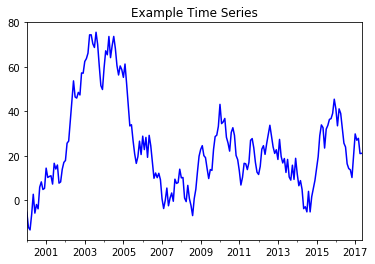

2000-01-31    -5.346300
2000-02-29   -12.135548
2000-03-31   -13.289117
2000-04-30    -6.312930
2000-05-31     2.730633
2000-06-30    -5.733345
2000-07-31    -1.857893
2000-08-31    -3.807481
2000-09-30     5.929088
2000-10-31     8.305036
Freq: M, dtype: float64

In [2]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model. Note the shape of the arrays.

In [10]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
# print (len(x_batches))
print (x_batches.shape)
# print (x_batches[0:2])

# print (y_batches[0:1])
print (y_batches.shape)

(10, 20, 1)
(10, 20, 1)


In [11]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
# print (X_test)

(1, 20, 1)


In [12]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables


In [13]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 249812.0
100 	MSE: 7898.63
200 	MSE: 3091.03
300 	MSE: 1786.7
400 	MSE: 1334.11
500 	MSE: 1159.55
600 	MSE: 1150.26
700 	MSE: 970.983
800 	MSE: 881.546
900 	MSE: 795.716
[[[ 34.82762527]
  [ 35.89331818]
  [ 41.10429764]
  [ 43.73707581]
  [ 32.17472458]
  [ 30.5610199 ]
  [ 44.55562592]
  [ 42.51691818]
  [ 26.46440697]
  [ 21.6620903 ]
  [ 22.80078888]
  [ -1.81233943]
  [  9.29471874]
  [ 33.46632767]
  [-18.15171623]
  [ 20.59003639]
  [ 45.55469513]
  [ 10.16679287]
  [ 37.57590485]
  [ 34.6147995 ]]]


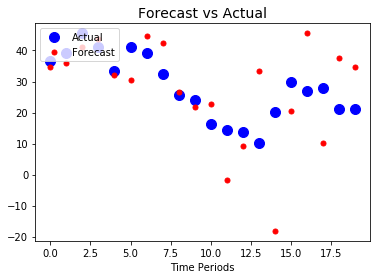

In [14]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()